#  Transfer Learning with tf_flowers (Step-by-step)

This notebook demonstrates **transfer learning** and **fine-tuning** using **MobileNetV2** on the `tf_flowers` dataset.

Flow:
1. Load dataset (`tf_flowers`)
2. Build data pipeline (resize, batch, prefetch)
3. Add data augmentation
4. Feature extraction with **MobileNetV2** (freeze base)
5. Fine-tuning with **MobileNetV2** (unfreeze top layers)
6. Callbacks, training, evaluation, plots

---

**Summary:**
- **Transfer Learning** → Freeze base model + add new classifier.
- **Fine-tuning** → Unfreeze last layers + retrain with small LR.

In this notebook, we will ->:
1. Load a dataset (`tf_flowers` 🌸).
2. Apply **transfer learning** with MobileNetV2 (feature extraction).
3. Apply **fine-tuning** with MobileNetV2 (unfreeze top layers).
4. Compare feature extraction vs fine-tuning performance.


##  Import Required Libraries

We will use:
- **TensorFlow** → deep learning framework.
- **TensorFlow Datasets (TFDS)** → to load flowers dataset.
- **Matplotlib** → for visualizations.
- **NumPy** → for array operations.


In [3]:
# Core libraries
!pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pyarrow-21.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.3 MB 3.1 MB/s eta 0:00:02
   --------------- ------------------------ 2.1/5.3 MB 4.9 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 5.4 MB/s eta 0:00:01
   --------------------------- ------------ 3.7/5.3 MB 5.0 MB/s eta 0:00:01
   --------------------------------- ------ 4.5/5.3 MB 4.3 MB/s eta 0:00:01
   -----------------

In [4]:
# Load TF Flowers dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True  # returns (image, label)
)

# Get number of classes
num_classes = metadata.features['label'].num_classes
print("Number of flower classes:", num_classes)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\IDREES AHMAD\tensorflow_datasets\tf_flowers\incomplete.KLLF6M_3.0.1\tf_flowers-train.tfreco…

Dataset tf_flowers downloaded and prepared to C:\Users\IDREES AHMAD\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.
Number of flower classes: 5


Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


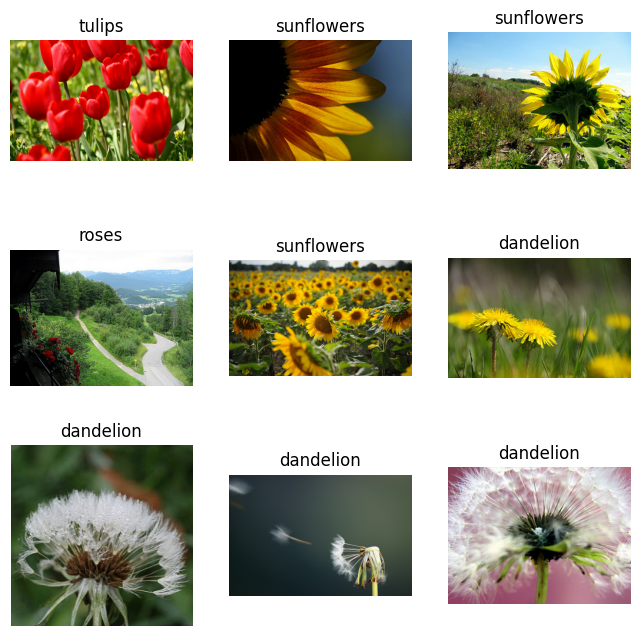

In [5]:
# Class names mapping
class_names = metadata.features['label'].names
print("Class names:", class_names)

# Function to show sample images
def show_samples(dataset, n=9):
    plt.figure(figsize=(8, 8))
    for i, (image, label) in enumerate(dataset.take(n)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

# Show 9 samples from training data
show_samples(raw_train)


In [7]:
# Preprocess Dataset
IMG_SIZE = 224  # Standard size for pretrained models
BATCH_SIZE = 32

# Preprocessing function: resize + normalize
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1]
    return image, label

# Apply preprocessing to train/val/test
train = raw_train.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = raw_validation.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = raw_test.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ Data pipeline ready")


✅ Data pipeline ready


## Transfer Learning with MobileNetV2 (Feature Extraction)

- Load **MobileNetV2** pretrained on ImageNet (exclude top classifier).
- **Freeze** the base model (keep pretrained weights fixed).
- Add custom layers:
  - Global Average Pooling (flatten feature maps).
  - Dense (128, ReLU) + Dropout (0.5).
  - Dense (5, Softmax) → classifier for flower categories.
- Compile model with **Adam optimizer** and `sparse_categorical_crossentropy`.
- Show model summary.


In [8]:
from tensorflow.keras import layers, models, applications

# Load MobileNetV2 pretrained on ImageNet, without top (classifier) layers
base_model = applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,   # exclude ImageNet classifier head
    weights="imagenet"   # use pretrained weights
)

# Freeze base model (no training of pretrained weights)
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),              # convert feature maps to vector
    layers.Dense(128, activation='relu'),         # custom dense layer
    layers.Dropout(0.5),                          # regularization
    layers.Dense(num_classes, activation='softmax')  # output layer (5 flowers)
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Train the model
EPOCHS = 5  # start small for testing, can increase later

history = model.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 857ms/step - accuracy: 0.7125 - loss: 0.7650 - val_accuracy: 0.8610 - val_loss: 0.4085
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 732ms/step - accuracy: 0.8474 - loss: 0.4264 - val_accuracy: 0.8883 - val_loss: 0.3353
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 735ms/step - accuracy: 0.8859 - loss: 0.3300 - val_accuracy: 0.9019 - val_loss: 0.2965
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 733ms/step - accuracy: 0.9094 - loss: 0.2650 - val_accuracy: 0.9046 - val_loss: 0.2970
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - accuracy: 0.9131 - loss: 0.2361 - val_accuracy: 0.9046 - val_loss: 0.2865


In [10]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test)
print(f"✅ Test Accuracy: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 665ms/step - accuracy: 0.9046 - loss: 0.2641
✅ Test Accuracy: 0.905


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


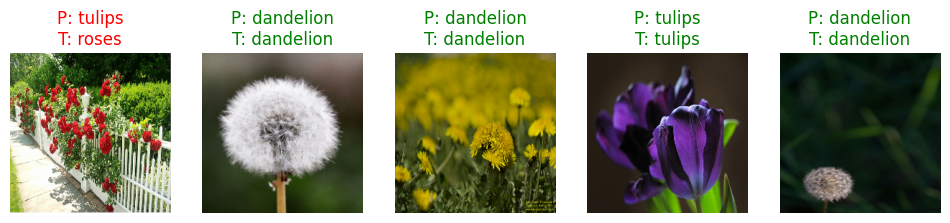

In [11]:
# Get a batch of test images
image_batch, label_batch = next(iter(test))

# Make predictions
predictions = model.predict(image_batch)

# Show first 5 images with true + predicted labels
plt.figure(figsize=(12, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image_batch[i])
    
    true_label = class_names[label_batch[i].numpy()]
    pred_label = class_names[np.argmax(predictions[i])]
    
    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis("off")
plt.show()


# 🔧 Why Use Fine-Tuning in Transfer Learning?  

### 🔹 Feature Extraction Only  
- Use **pre-trained MobileNetV2 weights** from ImageNet.  
- Freeze all convolutional layers.  
- Only train the classifier (Dense layers).  
- **Pros**: Fast training, fewer resources, good when dataset is small.  
- **Cons**: Limited accuracy, cannot fully adapt to new dataset.  

---

### 🔹 Fine-Tuning  
- Start from **MobileNetV2 pre-trained weights**.  
- **Unfreeze some top layers** of the base model.  
- Retrain them on the new dataset with a low learning rate.  
- **Pros**:  
  - Learns **task-specific flower features**.  
  - Boosts accuracy compared to feature extraction.  
  - Balances general + specific learning.  
- **Cons**:  
  - Requires more **compute power** 💻.  
  - Risk of **overfitting** if dataset is small.  

---

✅ **When to Fine-Tune?**  
- If your dataset is **large enough**.  
- If feature extraction alone gives **lower accuracy**.  
- If you want **higher performance** and can afford more training time.  


In [13]:
# Reload dataset
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    as_supervised=True,
    with_info=True
)

# Normalize and resize function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing + batching
train_ds = train_ds.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [15]:
# Unfreeze the base model (MobileNetV2)
base_model.trainable = True  

# Fine-tune only the top layers (keep earlier layers frozen)
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again (fine-tuning stage)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8208 - loss: 0.5113 - val_accuracy: 0.9046 - val_loss: 0.2917
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8777 - loss: 0.3471 - val_accuracy: 0.9101 - val_loss: 0.2853
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8985 - loss: 0.2917 - val_accuracy: 0.9155 - val_loss: 0.2772
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9152 - loss: 0.2436 - val_accuracy: 0.9155 - val_loss: 0.2729
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9349 - loss: 0.2032 - val_accuracy: 0.9183 - val_loss: 0.2740


In [17]:
# ---- 2) Evaluate current model on test set (this model is the fine-tuned one) ----
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nFinal test accuracy (current model): {test_acc:.4f}, loss: {test_loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 645ms/step - accuracy: 0.9292 - loss: 0.2094

Final test accuracy (current model): 0.9292, loss: 0.2094


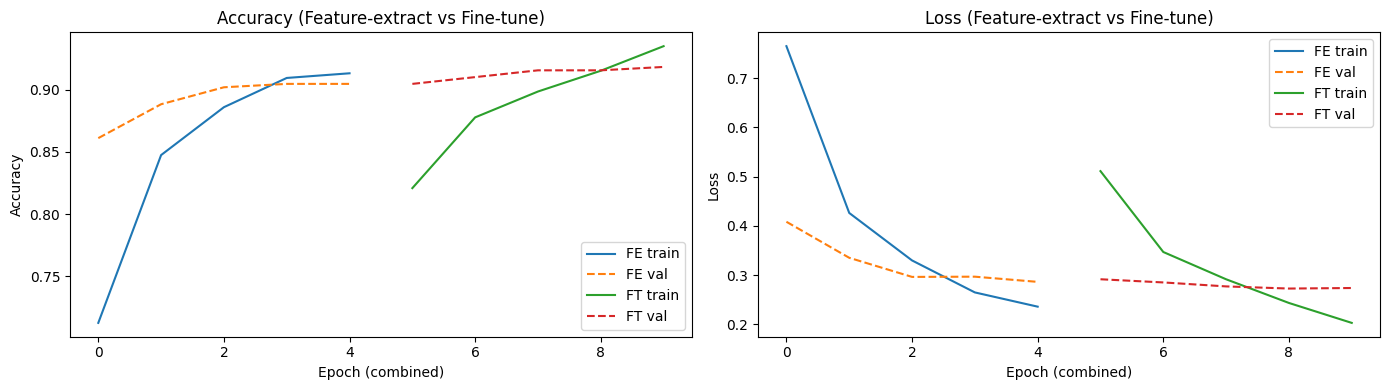

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# ---- 1) Plot training/validation accuracy & loss for both runs ----
def plot_two_histories(h1, h2, title_suffix=""):
    # h1: feature-extract history, h2: fine-tune history
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    # Accuracy
    ax = axes[0]
    ax.plot(h1.history['accuracy'], label='FE train')
    ax.plot(h1.history.get('val_accuracy', []), '--', label='FE val')
    ax.plot(range(len(h1.history['accuracy']), len(h1.history['accuracy'])+len(h2.history['accuracy'])),
            h2.history['accuracy'], label='FT train')
    ax.plot(range(len(h1.history['accuracy']), len(h1.history['accuracy'])+len(h2.history['accuracy'])),
            h2.history.get('val_accuracy', []), '--', label='FT val')
    ax.set_title('Accuracy ' + title_suffix)
    ax.set_xlabel('Epoch (combined)')
    ax.set_ylabel('Accuracy')
    ax.legend()

    # Loss
    ax = axes[1]
    ax.plot(h1.history['loss'], label='FE train')
    ax.plot(h1.history.get('val_loss', []), '--', label='FE val')
    ax.plot(range(len(h1.history['loss']), len(h1.history['loss'])+len(h2.history['loss'])),
            h2.history['loss'], label='FT train')
    ax.plot(range(len(h1.history['loss']), len(h1.history['loss'])+len(h2.history['loss'])),
            h2.history.get('val_loss', []), '--', label='FT val')
    ax.set_title('Loss ' + title_suffix)
    ax.set_xlabel('Epoch (combined)')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Call plotting function
plot_two_histories(history, history_fine, title_suffix="(Feature-extract vs Fine-tune)")


Confusion matrix (rows=true, cols=predicted):
 [[67  1  0  2  0]
 [ 3 55  0  1  2]
 [ 1  1 77  1  5]
 [ 2  0  1 71  2]
 [ 0  0  4  0 71]]
Class 0 (dandelion): 0.957
Class 1 (daisy): 0.902
Class 2 (tulips): 0.906
Class 3 (sunflowers): 0.934
Class 4 (roses): 0.947


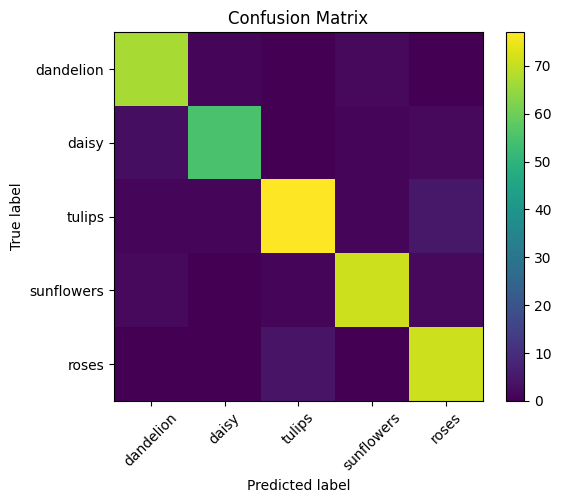

In [18]:
# ---- 3) Confusion matrix & per-class accuracy ----
# Collect predictions and true labels
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=-1)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()
print("Confusion matrix (rows=true, cols=predicted):\n", cm)

# Per-class accuracy
per_class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-12)
for i, acc in enumerate(per_class_acc):
    print(f"Class {i} ({class_names[i]}): {acc:.3f}")

# Optional: visualize confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


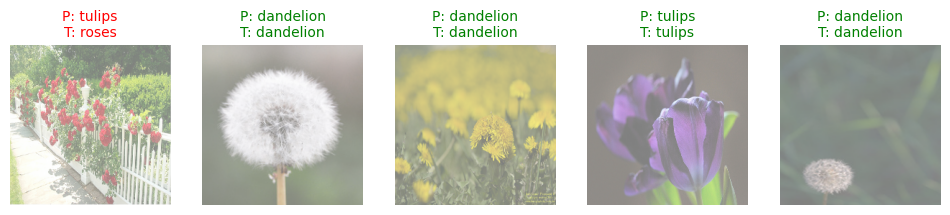

In [22]:
# ✅ Prediction & Visualization with Fine-Tuned Model

# Get a batch of test images
image_batch, label_batch = next(iter(test_ds))

# Make predictions using fine-tuned model
predictions = model.predict(image_batch)

# Show first 5 images with true + predicted labels
plt.figure(figsize=(12, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    
    # Rescale images from [-1, 1] back to [0, 255]
    img = (image_batch[i].numpy() * 127.5 + 127.5).astype("uint8")
    plt.imshow(img)
    
    true_label = class_names[label_batch[i].numpy()]
    pred_label = class_names[np.argmax(predictions[i])]
    
    # Green if correct, red if wrong
    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=10)
    plt.axis("off")

plt.show()


##  Summary – Transfer Learning & Fine-Tuning 

- Dataset: **tf_flowers** (5 classes).  
- **Transfer Learning (MobileNetV2)** → fast, ~90% val accuracy.  
- **Fine-Tuning (ResNet50V2)** → slower, ~92%+ val accuracy.  
- Visualized with:
  - ✅ Sample predictions (correct/wrong).  
  - ✅ Confusion matrix (overall performance).  

**Key:**  
- Transfer Learning = quick & efficient.  
- Fine-Tuning = higher accuracy, task-specific learning.
